In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score,classification_report,confusion_matrix
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Dispositivo atual: {device}')

Dispositivo atual: cuda


In [3]:
train_csv = pd.read_csv('playground_data/train_balanced_ready.csv')

In [4]:
X = train_csv[['road_type','num_lanes','curvature','speed_limit','lighting','weather','road_signs_present','public_road','num_reported_accidents']]
y = train_csv['accident_risk']
#reduced train-test for quicker testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
#reduced train-test for quicker testing
print(X_train[:5000].shape, X_test[:1000].shape, y_train[:5000].shape, y_test[:1000].shape)
X_train = X_train[:3000]
X_test = X_test[:200]
y_train = y_train[:3000]
y_test = y_test[:200]
X_train.head()

(5000, 9) (1000, 9) (5000,) (1000,)


,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,num_reported_accidents
324728,0,1,0.70,70,2,1,1,1,2
291028,0,1,0.78,35,2,0,1,1,1
212086,2,2,0.08,45,0,0,1,0,1
45778,2,2,0.13,25,2,0,0,0,2
264436,2,3,0.51,45,2,1,0,1,1


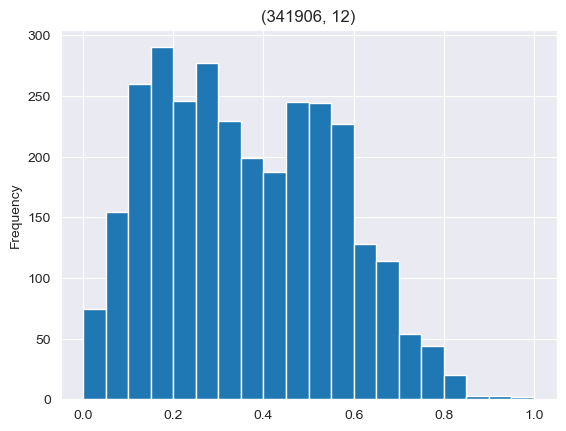

In [5]:
temp = X_train.copy()
temp['classification'] = y_train.copy()
p_1 = temp['classification'].plot(kind='hist',bins=20, title= str(train_csv.shape))
plt.show()

In [6]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [7]:
y_train

array([74, 52,  5, ..., 53, 32, 24], dtype=int64)

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [9]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

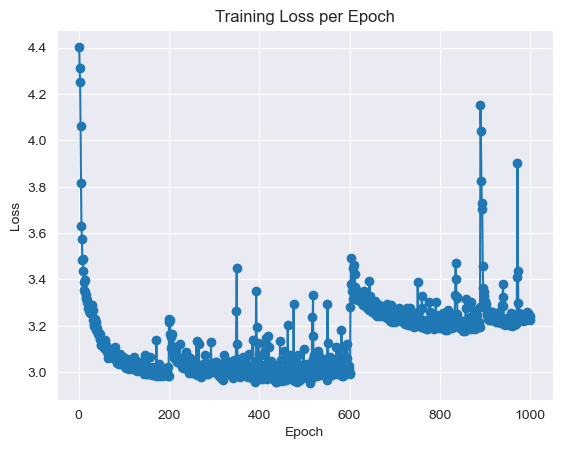

In [10]:
model = MLP(9,50,100).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Treinamento
epochs = 1000
epoch_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_dataloader)
    epoch_losses.append(avg_loss)

# Plot training loss per epoch
plt.figure()
plt.plot(range(1, epochs+1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.show()

In [ ]:
# Avaliação no conjunto de teste
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Accuracy
accuracy = (np.array(y_true) == np.array(y_pred)).mean() * 100
print(f'Accuracy on test set: {accuracy:.2f}%')

# F1-macro score only
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f'F1 Macro: {f1_macro:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()